In [1]:
import uproot 
import numpy as np
import coffea
from coffea.nanoaod import NanoEvents
from coffea.nanoaod.methods.leptons import *
from coffea import hist
import matplotlib.pyplot as plt

In [2]:
fname="/uscms/home/therwig/nobackup/public/forDominic/CRAB3_sos_28may2020_testHinoProd_nano.root"
events = NanoEvents.from_file(fname,methods={"ElectronBPark":Electron})

In [3]:
def makeroc(sig, bkg, binning, direction=1):
    '''Given a signal and background discriminant array, along with a binning,
    compute the ROC curve by integrating discriminant histograms along a direction:
        1: cut < value
        -1: cut >= value
    Returns a tuple of (signal efficiency, background efficiency)'''
    sighist, _ = np.histogram(sig, bins=binning)
    bkghist, _ = np.histogram(bkg, bins=binning)
    # numpy histogram will ignore values out of range of our binning (overflow)
    # so add the overflow values that would pass given our cut direction
    if direction == 1:
        sighist[0] += sum(sig < binning[0])
        bkghist[0] += sum(bkg < binning[0])
    elif direction == -1:
        sighist[-1] += sum(sig > binning[-1])
        bkghist[-1] += sum(bkg > binning[-1])
    else:
        raise ValueError("Invalid direction")
    sigpass = (np.cumsum(sighist[::direction]) / len(sig))[::direction]
    bkgpass = (np.cumsum(bkghist[::direction]) / len(bkg))[::direction]
    return (sigpass, bkgpass)


def cut(electrons):
    return electrons[
        (electrons.pt > 1)
        & (abs(electrons.eta) < 1.4) & (electrons.pt<5)
    ]

eles = events.ElectronBPark.cross(events.GenPart[events.GenPart.pdgId == 11], nested=True)
mask = ((eles.i0.delta_r(eles.i1)).min() < 0.05) & (events.ElectronBPark.pt<5) & (events.ElectronBPark.pt>1)
unmask = ((eles.i0.delta_r(eles.i1)).min() >= 0.05) & (events.ElectronBPark.pt<5) & (events.ElectronBPark.pt>1)

#correct unmatched
matched_electrons = events.ElectronBPark[mask].flatten()
unmatched_electrons = events.ElectronBPark[unmask].flatten()

In [4]:
roc_mva = makeroc(
    sig=cut(matched_electrons).mvaId,
    bkg=cut(unmatched_electrons).mvaId,
    binning=np.linspace(-10, 30, 80),
    direction=-1,
)


In [58]:
mask_cut = (((eles.i0.delta_r(eles.i1)).min() < 0.05) 
            & (events.ElectronBPark.pt<5) 
            & (events.ElectronBPark.pt>1) 
            #& (events.ElectronBPark.mvaId > -1) 
           & (events.ElectronBPark.dz < 15) 
            & (events.ElectronBPark.ip3d < 5) 
           & (events.ElectronBPark.dxy < 0.1) 
            & (events.ElectronBPark.trkRelIso < 0.5))
unmask_cut = (((eles.i0.delta_r(eles.i1)).min() >= 0.05) 
              & (events.ElectronBPark.pt<5) 
            & (events.ElectronBPark.pt>1) 
              #& (events.ElectronBPark.mvaId > -1) 
           & (events.ElectronBPark.dz < 15) 
              & (events.ElectronBPark.ip3d < 5) 
             & (events.ElectronBPark.dxy < 0.1) 
              & (events.ElectronBPark.trkRelIso < 0.5))

matched_electrons_cut = events.ElectronBPark[mask_cut].flatten()
unmatched_electrons_cut = events.ElectronBPark[unmask_cut].flatten()
roc_mva_cut = makeroc(
    sig=cut(matched_electrons_cut).mvaId,
    bkg=cut(unmatched_electrons_cut).mvaId,
    binning=np.linspace(-10, 30, 80),
    direction=-1,
)

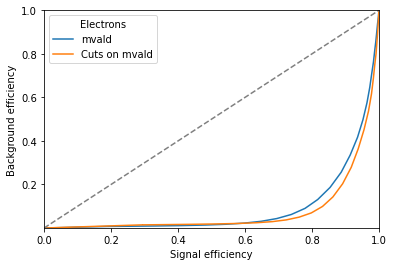

In [59]:
fig, ax = plt.subplots()

ax.plot(*roc_mva, label=r"mvaId")
ax.plot(*roc_mva_cut, label=r"Cuts on mvaId")
diag = np.linspace(0, 1, 100)
ax.plot(diag, diag, color='grey', linestyle='--')
ax.set_xlabel("Signal efficiency")
ax.set_ylabel("Background efficiency")
ax.set_xlim(0, 1)
ax.set_ylim(1e-3, 1)
# ax.set_yscale('log')
ax.legend(title=r'Electrons')

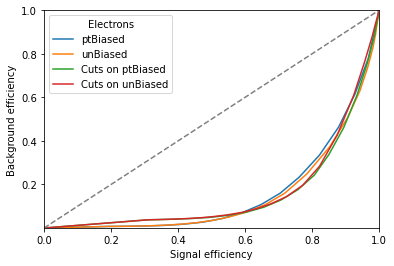

In [56]:
roc_ptBiased = makeroc(
    sig=cut(matched_electrons).ptBiased,
    bkg=cut(unmatched_electrons).ptBiased,
    binning=np.linspace(-10, 30, 80),
    direction=-1,
)

roc_unBiased = makeroc(
    sig=cut(matched_electrons).unBiased,
    bkg=cut(unmatched_electrons).unBiased,
    binning=np.linspace(-10, 30, 80),
    direction=-1,
)

roc_ptBiased_cut = makeroc(
    sig=cut(matched_electrons_cut).ptBiased,
    bkg=cut(unmatched_electrons_cut).ptBiased,
    binning=np.linspace(-10, 30, 80),
    direction=-1,
)

roc_unBiased_cut = makeroc(
    sig=cut(matched_electrons_cut).unBiased,
    bkg=cut(unmatched_electrons_cut).unBiased,
    binning=np.linspace(-10, 30, 80),
    direction=-1,
)

fig2, ax2 = plt.subplots()

ax2.plot(*roc_ptBiased, label=r"ptBiased")
ax2.plot(*roc_unBiased, label=r"unBiased")
ax2.plot(*roc_ptBiased_cut, label=r"Cuts on ptBiased")
ax2.plot(*roc_unBiased_cut, label=r"Cuts on unBiased")
ax2.plot(diag, diag, color='grey', linestyle='--')
ax2.set_xlabel("Signal efficiency")
ax2.set_ylabel("Background efficiency")
ax2.set_xlim(0, 1)
ax2.set_ylim(1e-3, 1)
# ax2.set_yscale('log')
ax2.legend(title=r'Electrons')